# Extension of Albu to RGB Only
So far unsuccessful attempt to make the model work with only 3 channels again. Currently in progress.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.grid':False})
import cv2
import numpy as np
import georaster
import torch
import json
import os
from pytorch_utils.eval import read_model, flip
from nbutils import thresh, score_pred, load_img, make_input_tensor, predict_on_file, get_saliency_big, plot_poly
from config import Config
%matplotlib inline

# Model Surgery

We just remove the depth channel of the input conv layer

In [20]:
cfg = Config(**json.load(open("../resnet34_1x1080_retrain.json", 'r')))
rgb_model = read_model(cfg, 4)
first_conv = rgb_model.encoder_stages[0][0]
first_conv.weight.data = first_conv.weight.data[:, :3, :, :]
depth_model = read_model(cfg, 4)
first_conv = depth_model.encoder_stages[0][0]
first_conv.weight.data = first_conv.weight.data[:, 3:, :, :]

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
def plot_poly_saliency(fname, lblname, model, channels=4, left=None, right=None, sal_factor=10,
                       fig=fig):
    TRUE_COLOR = (0, 0.2, 0.9, 0.6)
    PRED_COLOR = (0, 0.9, 0, 0.4)
    img = load_img(fname)
    dsm = georaster.SingleBandRaster(fname.replace("RGB", "DSM")).r
    dtm = georaster.SingleBandRaster(fname.replace("RGB", "DTM")).r
    dem_img = (dsm - dtm) / 9.0
    del(dsm)
    del(dtm)
    geo_img = georaster.SingleBandRaster(lblname)
    lbl = geo_img.r - 2
    output = predict_on_file(model, fname, channels=channels)
    get_ctr = lambda out: cv2.findContours(cv2.threshold(out, 127, 255, 0)[1], 
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)[1]
    if left is None and right is None:
        fig, ax = plt.subplots(figsize=(15,10), ncols=2)
        left, right = ax
    x_coord_func = lambda value, tick_num: "{0:<.5f}".format(geo_img.coordinates(*geo_img.coord_to_px(value, 0), latlon=True)[0])
    y_coord_func = lambda value, tick_num: "{0:<.5f}".format(geo_img.coordinates(*geo_img.coord_to_px(0, value), latlon=True)[1])
    
    left.imshow(img, extent=geo_img.extent)
    plot_poly(get_ctr(lbl*255), left, geo_img.coordinates, TRUE_COLOR)
    plot_poly(get_ctr(output), left, geo_img.coordinates, PRED_COLOR)
    left.set_title("F1/IOU = {0:<.5f} [Blue=Truth,Green=Predicted]".format(score_pred(output, lbl)),
                  fontsize=18)
    if channels == 1:
        input_tensor = np.expand_dims(np.expand_dims(dem_img, axis=0), axis=0)
    if channels == 3:
        input_tensor = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
    if channels == 4:
        input_tensor = make_input_tensor(img, dem_img)
    sal = get_saliency_big(model, torch.Tensor(input_tensor), lbl)
#     right.imshow((sal * 255).astype(np.uint8), cmap='hot', extent=geo_img.extent)
    right.imshow(np.clip(np.dstack((img / 255.0, sal_factor*sal)), 0, 1), extent=geo_img.extent)
    PRED_LIGHT = (*PRED_COLOR[:-1], 0.05)
    right.set_title("Saliency Map with Predicted labels", fontsize=18)
    
    # Fix the labels to be latlon
    for a in [left, right]:
        a.xaxis.set_major_formatter(plt.FuncFormatter(x_coord_func))
        a.yaxis.set_major_formatter(plt.FuncFormatter(y_coord_func))
    right.xaxis.set_data_interval(*left.xaxis.get_data_interval())
    right.yaxis.set_data_interval(*left.yaxis.get_data_interval())
    fig.tight_layout()
    return fig

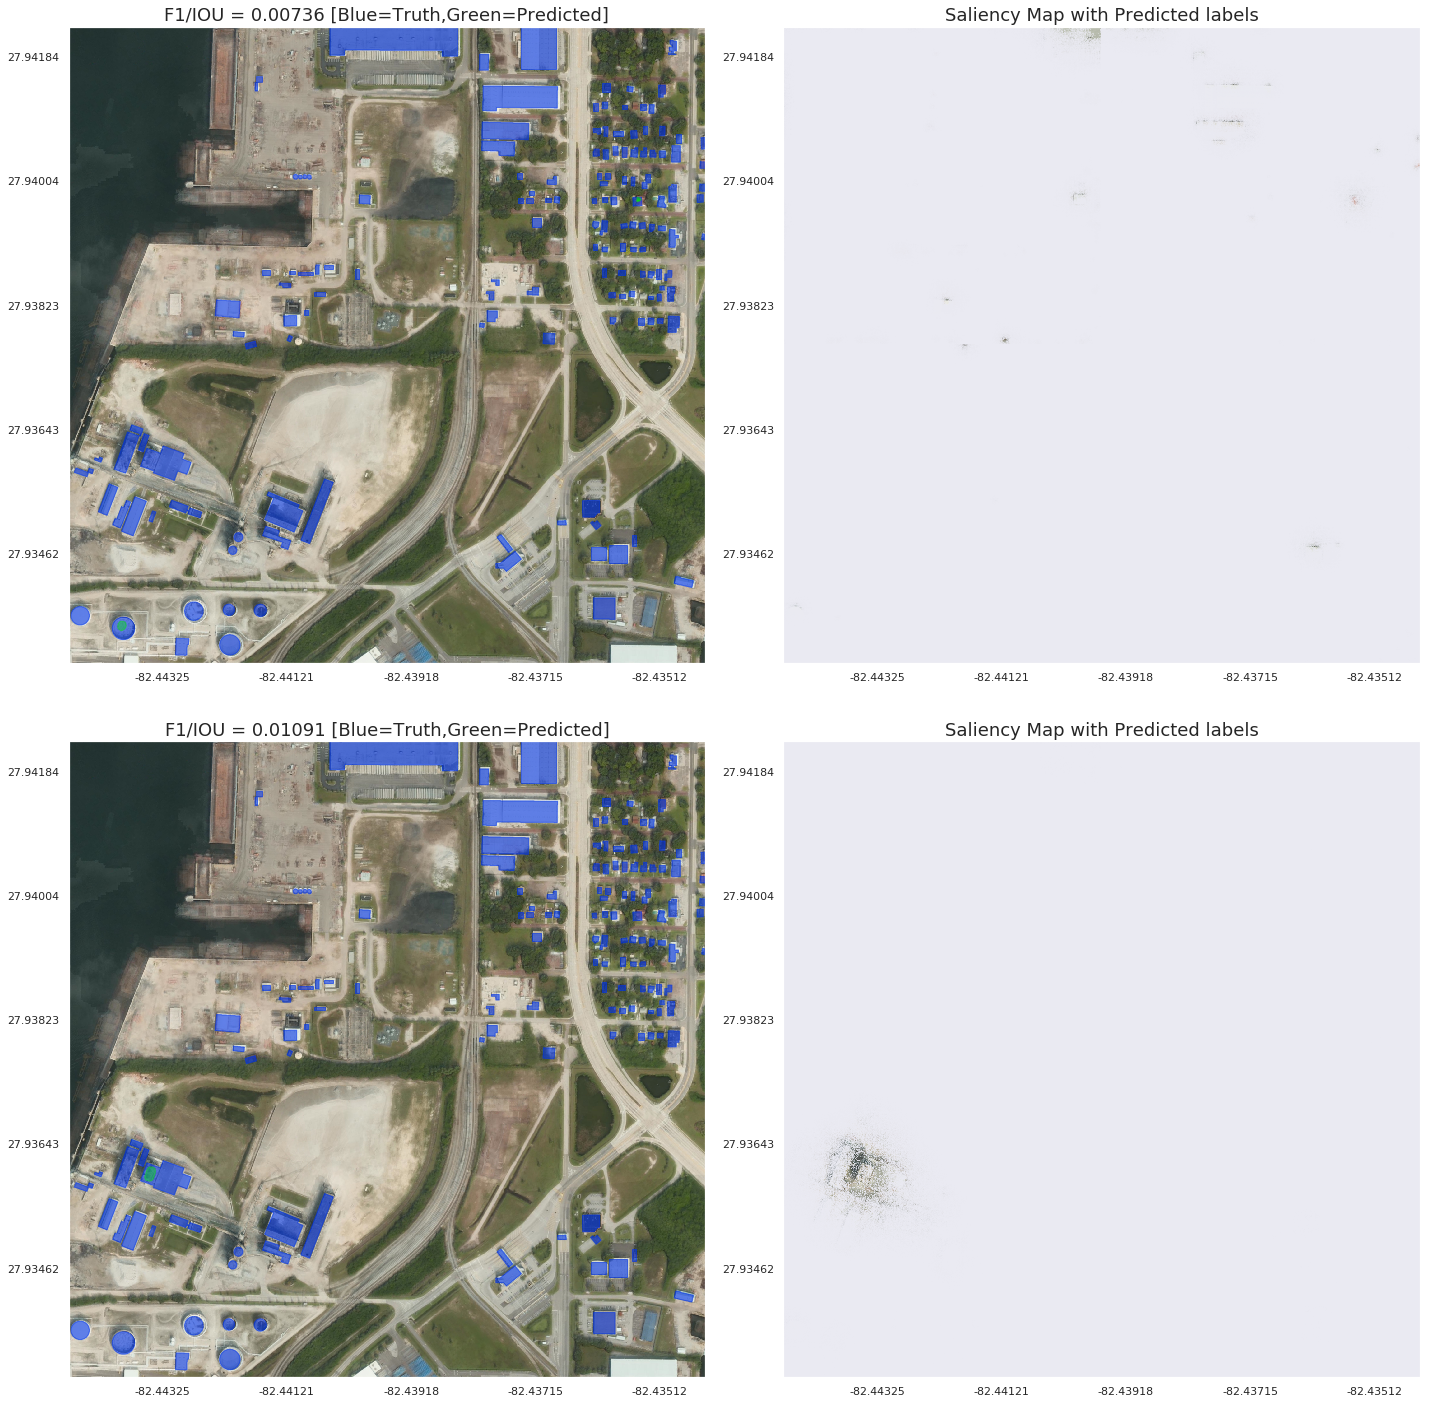

In [31]:
indir = '../../Train/Inputs/'
truthdir = '../../Train/GT/'
samples = 1
for i in range(samples):
    name = np.random.choice(os.listdir(indir))[:-7] + "RGB.tif"
    fname = indir + name
    lblname = truthdir + name.replace("RGB", "GTL")
    lbl = georaster.SingleBandRaster(lblname).r - 2
    lbl = thresh(lbl * 255)
#     output3 = predict_on_file(rgb_model, fname, crop=True, channels=3)
#     print("F1 / IOU with crop + flip:", 
#       score_pred(thresh(output3),lbl))
#     print("F1 / IOU with no crop + flip:", 
#       score_pred(thresh(predict_on_file(rgb_model, fname, crop=False, channels=3)), lbl))
#     print("F1 / IOU with no crop + no flip:",
#      score_pred(thresh(predict_on_file(rgb_model, fname, crop=False, channels=3, flips=flip.FLIP_NONE)), lbl))
    fig, ax = plt.subplots(figsize=(20,20), nrows=2, ncols=2)
    plot_poly_saliency(fname, lblname, rgb_model, channels=3, left=ax[0,0], right=ax[0,1], fig=fig)
    plot_poly_saliency(fname, lblname, depth_model, channels=1, left=ax[1,0], right=ax[1,1], fig=fig)
    fig.savefig(f"RGBandDSM-{name[:-4]}", dpi=200)